In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from state_space_setup import *

In [2]:
cost_matrix = np.load("cost_matrix.npy")
policy = pd.read_csv('policy.csv')

# format and extract the maximum number of parts from the loaded policy dataframe
policy['State'] = policy['State'].apply(lambda x: tuple(map(int, x.strip('()').split(','))))
maximum_parts = policy['State'].apply(lambda x: x[0]).max()
print("Maximum number of parts in the inventory:", maximum_parts)

# generate the state space
state_space = get_state_space(maximum_parts)
state_tuples = list(map(tuple, state_space))

Maximum number of parts in the inventory: 41


In [3]:
def transition_probabilities(old_state, new_state, action, p=0.9, lambda_=2):

    if new_state[1] == 0:
        if (old_state[1] == 0) and (action == 0):
            prob = 1
        else:
            prob = p

        if new_state[0] <= (old_state[0] + old_state[1] + action) and new_state[0] > (old_state[1] + action):
            prob *= stats.poisson.pmf(old_state[0] + old_state[1] + action - new_state[0], mu=lambda_)
        elif new_state[0] == (old_state[1] + action):
            prob *= stats.poisson.sf(old_state[0] - 1, mu=lambda_)
        else:
            prob = 0
    elif new_state[1] == (old_state[1] + action):
        prob = 1 - p
        if new_state[0] <= old_state[0] and new_state[0] > 0:
            prob *= stats.poisson.pmf(old_state[0] - new_state[0],mu=lambda_)
        elif new_state[0] == 0:
            prob *= stats.poisson.sf(old_state[0] - 1, mu=lambda_)
        else:
            prob = 0
    else:
        prob = 0
    return prob


def expected_action_value(current_state, action, values):
    global maximum_parts
    global cost_matrix
    global trans_prob_matrix

    discount_factor = 0.995

    current_state_idx = get_index(current_state[0], current_state[1], maximum_parts)

    probs = trans_prob_matrix[current_state_idx, :, action]
    costs = cost_matrix[current_state_idx, :, action]
    expected_value = np.dot(probs, costs + discount_factor * values)
    return expected_value

In [4]:
delivery_probabilities = np.arange(0.25, 1.01, 0.05)
policies = np.zeros((len(delivery_probabilities), 2))

# Value iteration setup
error = 1e-3
values = np.zeros(len(state_space))
delta = 2 * error


# Value iteration
for k, prob in enumerate(delivery_probabilities):
    trans_prob_matrix = np.zeros((len(state_space), len(state_space), maximum_parts + 1))
    for i, s_old in enumerate(state_space):
        for j, s_new in enumerate(state_space):
            for a in range(maximum_parts + 1):
                trans_prob_matrix[i, j, a] = transition_probabilities(s_old, s_new, a, p=prob, lambda_=1)


    while delta >= error:
        delta = 0
        old_values = np.copy(values)
        for i, state in enumerate(state_space):
            v = values[i]
            action_space = get_action_space(state, maximum_parts)
            action_costs = np.array([
                expected_action_value(state, act, old_values)
                for act in action_space
            ])
            values[i] = np.min(action_costs)
            delta = max(delta, abs(v - values[i]))
        

    policy_records = []
    for state in state_tuples:
        action_space = get_action_space(state, maximum_parts)
        action_costs = np.array([
            expected_action_value(state, act, values)
            for act in action_space
        ])
        order = action_space[np.argmin(action_costs)]
        policy_records.append((state, order))

    policy_df = pd.DataFrame(policy_records, columns=["State", "Order_size"])
    policy_df["IP"] = policy_df["State"].apply(sum)
    policy_df["New_IP"] = policy_df["IP"] + policy_df["Order_size"]
    filtered_policy_df = policy_df[policy_df["Order_size"] != 0]
    s = filtered_policy_df["IP"].max()
    S = filtered_policy_df["New_IP"].max()
    policies[k] = [s, S]
    print(f"Iteration {k + 1}/{len(delivery_probabilities)} completed. For delivery probability {prob} we get, s = {s}, S = {S}")
    values = np.zeros(len(state_space))
    delta = 2 * error

Iteration 1/16 completed. For delivery probability 0.25 we get, s = 26, S = 41
Iteration 2/16 completed. For delivery probability 0.3 we get, s = 22, S = 41
Iteration 3/16 completed. For delivery probability 0.35 we get, s = 19, S = 38
Iteration 4/16 completed. For delivery probability 0.39999999999999997 we get, s = 16, S = 36
Iteration 5/16 completed. For delivery probability 0.44999999999999996 we get, s = 15, S = 34
Iteration 6/16 completed. For delivery probability 0.49999999999999994 we get, s = 13, S = 32
Iteration 7/16 completed. For delivery probability 0.5499999999999999 we get, s = 12, S = 31
Iteration 8/16 completed. For delivery probability 0.5999999999999999 we get, s = 11, S = 29
Iteration 9/16 completed. For delivery probability 0.6499999999999999 we get, s = 10, S = 28
Iteration 10/16 completed. For delivery probability 0.7 we get, s = 9, S = 28
Iteration 11/16 completed. For delivery probability 0.7499999999999999 we get, s = 9, S = 27
Iteration 12/16 completed. For d

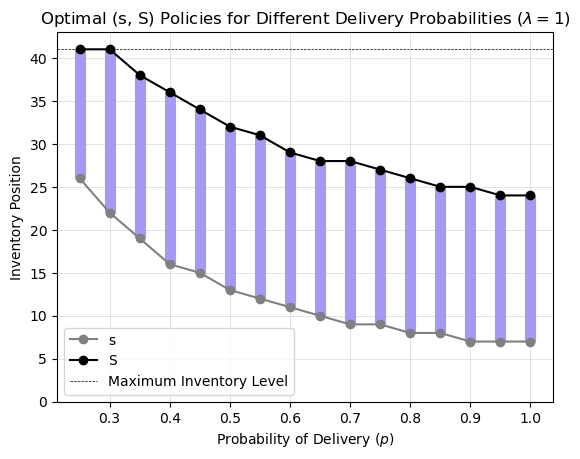

In [5]:
plt.vlines(delivery_probabilities, policies[:,0], policies[:,1], 
           color="#A499F4", alpha=1, linewidth=8)
plt.plot(delivery_probabilities, policies[:,0], "o-", label="s", color="gray")
plt.plot(delivery_probabilities, policies[:,1], "o-", label="S", color="black")
plt.xlabel("Probability of Delivery ($p$)")
plt.ylabel("Inventory Position")
plt.title("Optimal (s, S) Policies for Different Delivery Probabilities ($\\lambda=1$)")
plt.ylim(0, 43)
plt.axhline(41, color='black', linewidth=0.5, linestyle='--', label='Maximum Inventory Level')
plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.5)
plt.legend()
plt.savefig("plots/SA_delivery_probability_1.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [6]:
delivery_probabilities = np.arange(0.25, 1.01, 0.05)
policies2 = np.zeros((len(delivery_probabilities), 2))

# Value iteration setup
error = 1e-3
values = np.zeros(len(state_space))
delta = 2 * error


# Value iteration
for k, prob in enumerate(delivery_probabilities):
    trans_prob_matrix = np.zeros((len(state_space), len(state_space), maximum_parts + 1))
    for i, s_old in enumerate(state_space):
        for j, s_new in enumerate(state_space):
            for a in range(maximum_parts + 1):
                trans_prob_matrix[i, j, a] = transition_probabilities(s_old, s_new, a, p=prob, lambda_=2)


    while delta >= error:
        delta = 0
        old_values = np.copy(values)
        for i, state in enumerate(state_space):
            v = values[i]
            action_space = get_action_space(state, maximum_parts)
            action_costs = np.array([
                expected_action_value(state, act, old_values)
                for act in action_space
            ])
            values[i] = np.min(action_costs)
            delta = max(delta, abs(v - values[i]))
        

    policy_records = []
    for state in state_tuples:
        action_space = get_action_space(state, maximum_parts)
        action_costs = np.array([
            expected_action_value(state, act, values)
            for act in action_space
        ])
        order = action_space[np.argmin(action_costs)]
        policy_records.append((state, order))

    policy_df = pd.DataFrame(policy_records, columns=["State", "Order_size"])
    policy_df["IP"] = policy_df["State"].apply(sum)
    policy_df["New_IP"] = policy_df["IP"] + policy_df["Order_size"]
    filtered_policy_df = policy_df[policy_df["Order_size"] != 0]
    s = filtered_policy_df["IP"].max()
    S = filtered_policy_df["New_IP"].max()
    policies2[k] = [s, S]
    print(f"Iteration {k + 1}/{len(delivery_probabilities)} completed. For delivery probability {prob} we get, s = {s}, S = {S}")
    values = np.zeros(len(state_space))
    delta = 2 * error

Iteration 1/16 completed. For delivery probability 0.25 we get, s = 38, S = 41
Iteration 2/16 completed. For delivery probability 0.3 we get, s = 35, S = 41
Iteration 3/16 completed. For delivery probability 0.35 we get, s = 32, S = 41
Iteration 4/16 completed. For delivery probability 0.39999999999999997 we get, s = 28, S = 41
Iteration 5/16 completed. For delivery probability 0.44999999999999996 we get, s = 25, S = 41
Iteration 6/16 completed. For delivery probability 0.49999999999999994 we get, s = 22, S = 41
Iteration 7/16 completed. For delivery probability 0.5499999999999999 we get, s = 20, S = 41
Iteration 8/16 completed. For delivery probability 0.5999999999999999 we get, s = 18, S = 41
Iteration 9/16 completed. For delivery probability 0.6499999999999999 we get, s = 17, S = 41
Iteration 10/16 completed. For delivery probability 0.7 we get, s = 15, S = 41
Iteration 11/16 completed. For delivery probability 0.7499999999999999 we get, s = 14, S = 40
Iteration 12/16 completed. For

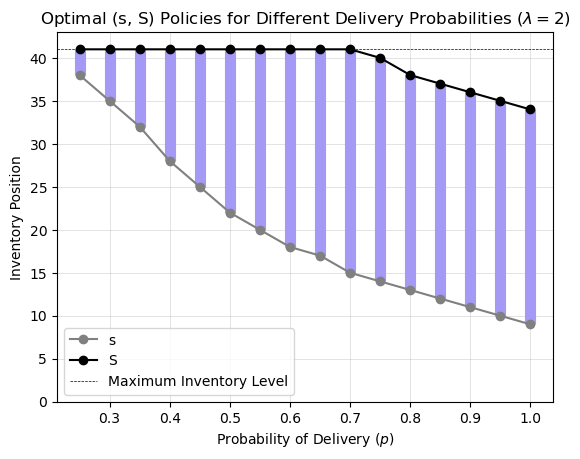

In [7]:
plt.vlines(delivery_probabilities, policies2[:,0], policies2[:,1], 
           color="#A499F4", alpha=1, linewidth=8)
plt.plot(delivery_probabilities, policies2[:,0], "o-", label="s", color="gray")
plt.plot(delivery_probabilities, policies2[:,1], "o-", label="S", color="black")
plt.xlabel("Probability of Delivery ($p$)")
plt.ylabel("Inventory Position")
plt.title("Optimal (s, S) Policies for Different Delivery Probabilities ($\\lambda=2$)")
plt.ylim(0, 43)
plt.axhline(41, color='black', linewidth=0.5, linestyle='--', label='Maximum Inventory Level')
plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.5)
plt.legend()
plt.savefig("plots/SA_delivery_probability_2.pdf", format="pdf", bbox_inches='tight')
plt.show()